### Install dependencies

In [ ]:
%pip install setuptools wheel
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
%pip install git+https://github.com/huggingface/diffusers.git
%pip install accelerate transformers peft pillow

### Install xformers

Xformers дает оптимизации по памяти. Но не всегда хорошо встает, например на WSL она не устанавливается почему-то.

In [ ]:
%pip install xformers

### Configuration

In [1]:
DEVICE = "cuda:0"
MODELS_PATH = "./models" # Path to pretrained lora models
LORA_NAME = "gpb-lora.safetensors"
REFERENCES_PATH = "./references" # Path to reference images for IP Adapter
REFERENCES_SIZE = (512, 512) # The size of reference images (all images will be resized to this size)
PROMPT = "a bucket of flowers, a box of chocolates, white background, monotonic background, masterpiece, best quality, high quality, highres"
NEGATIVE_PROMPT = "text, watermark, lowres, low quality, worst quality, deformed, glitch, low contrast, noisy, saturation, blurry"
HEIGHT = 1024 # Output image height
WIDTH = 1024 # Output image width
SEED = None # Set it to fixed number to debug model

### Load pipeline

In [2]:
import torch
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
from transformers import CLIPVisionModelWithProjection

image_encoder: CLIPVisionModelWithProjection = CLIPVisionModelWithProjection.from_pretrained(
  "h94/IP-Adapter",
  subfolder="models/image_encoder",
  torch_dtype=torch.float16,
)
image_encoder.to(DEVICE)

pipe: StableDiffusionPipeline = StableDiffusionPipeline.from_pretrained(
  "runwayml/stable-diffusion-v1-5",
  torch_dtype=torch.float16,
  image_encoder=image_encoder,
  variant="fp16",
)
pipe.to(DEVICE)
pipe.load_lora_weights(MODELS_PATH, weight_name=LORA_NAME)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = None
pipe.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="models",
  weight_name="ip-adapter_sd15.bin",
)

# Transfer style
pipe.set_ip_adapter_scale({
  "up": { "block_1": [1.0, 1.0, 1.0] }
})

# Transfer style and composition
# pipe.set_ip_adapter_scale({
#   "down": { "block_2": [1.0, 1.0] },
#   "mid": [1.0],
#   "up": { "block_1": [1.0, 1.0, 1.0] }
# })

pipe.enable_vae_tiling()
pipe.enable_model_cpu_offload()
# Uncomment this line if xformers installed for additional optimization
# pipe.enable_xformers_memory_efficient_attention()

generator = torch.Generator(DEVICE)
if SEED is not None:
    generator = generator.manual_seed(SEED)

/home/nitwof/projects/leaders2024/ml/sd/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nitwof/projects/leaders2024/ml/sd/.venv/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 12.31it/s]


### Load upscaler pipeline

In [3]:
import torch
from diffusers import StableDiffusionLatentUpscalePipeline

upscale_pipe: StableDiffusionLatentUpscalePipeline = StableDiffusionLatentUpscalePipeline.from_pretrained(
  "stabilityai/sd-x2-latent-upscaler",
  torch_dtype=torch.float16,
)
upscale_pipe.to(DEVICE)
upscale_pipe.enable_vae_tiling()
upscale_pipe.enable_model_cpu_offload()
# Uncomment this line if xformers installed for additional optimization
# upscale_pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


### Load reference images

In [4]:
import pathlib
from PIL import Image

ref_images = [
  Image.open(png).resize(REFERENCES_SIZE)
  for png in pathlib.Path(REFERENCES_PATH).glob("*.png")
]

### Generate image

100%|██████████| 30/30 [00:47<00:00,  1.57s/it]


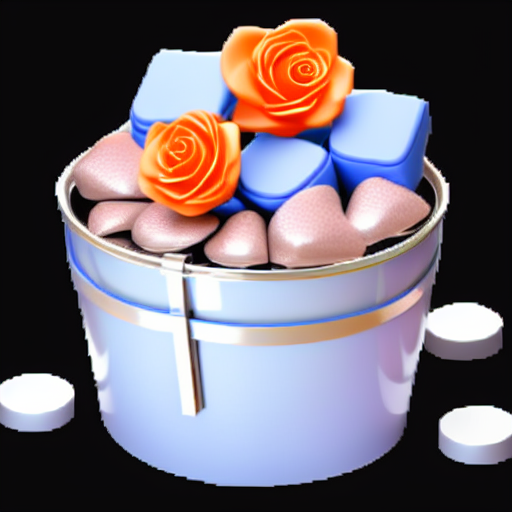

In [5]:
from IPython.display import display

image = pipe(
  prompt=PROMPT,
  negative_prompt=NEGATIVE_PROMPT,
  height=int(HEIGHT / 2),
  width=int(WIDTH / 2),
  ip_adapter_image=[ref_images],
  scale=1.0,
  guidance_scale=5,
  num_samples=1,
  num_inference_steps=30,
  generator=generator,
).images[0]

display(image)

### Upscale image

100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


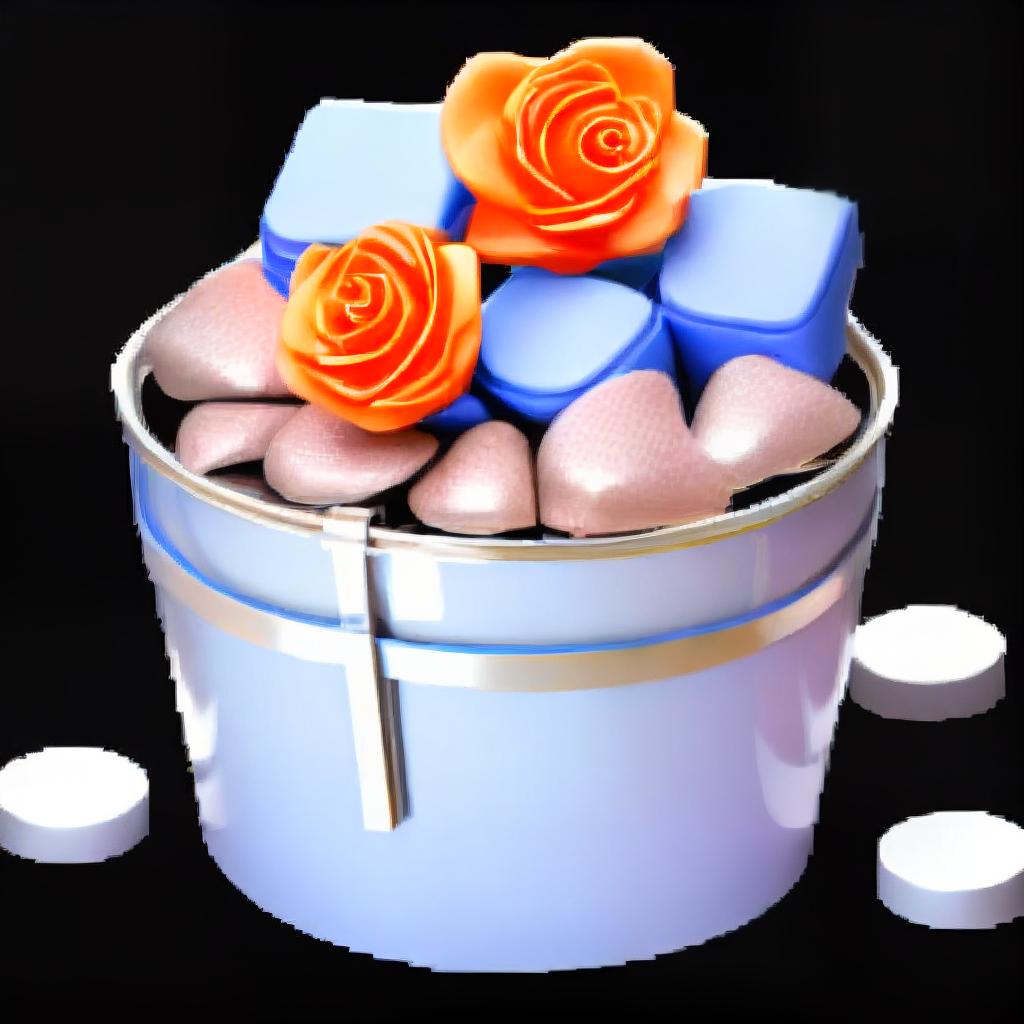

In [9]:
from IPython.display import display

upscaled_image = upscale_pipe(
  prompt=PROMPT,
  image=image,
  negative_prompt=NEGATIVE_PROMPT,
  generator=generator,
  num_inference_steps=30,
  guidance_scale=0,
).images[0]

display(upscaled_image)